# 1일차 종합실습 : 제조 공정간 불량 예측



## pulp-and-paper mill 공정
* 비즈니스 상황
    * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 이상 발생
    * 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실
    * 이를 사전에 감지하는 것은 굉장히 어려운 일입니다. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감 효과가 예상됩니다.

* Data
    * 행
        * 주어진 데이터에는 15일 동안 수집된 약 18,000개의 행의 시계열 데이터
        * 데이터는 2분 간격으로 측정.
    * 열 
        * y : normal – 0, abnormal - 1 (124건, 약 0.6%)
            * y 의 abnormal 데이터는 장애 발생 2~4분 전으로 시점에 대한 조정(shift)이 된(전처리 된) 데이터 입니다.
        * x1 - x61: 원자재, 부자재 및 공정 센서 값들로 구성됨.

* 장애 예방 조치
    * 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있습니다.
    * 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


![](https://keralakaumudi.com/web-news/en/2020/04/NMAN0141956/image/paper-mill.1.582102.jpg)

## 0.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV

### 2) 데이터셋 불러오기

In [2]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer2.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


### 3) 필요 함수들 생성

#### ① precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다. 
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [3]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    # f1, recall, precision curve
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')

    # f1를 최대화 해주는 threshold
    thre = round(thresholds[np.argmax(f1)],4)
    f1s = round(max(f1),4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline( f1s, color = 'darkred', linewidth = .7)
    plt.text(thre, .5, thre, color = 'darkred')
    plt.text(min(thresholds), f1s, f1s, color = 'darkred')

    plt.xlabel('Anomaly Score')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ② threshold로 잘랐을 때, 분류 평가 함수


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return confusion_matrix(y, pred_temp)

## 1.데이터 탐색

In [5]:
target = 'y'

* Target 변수의 class 비율을 확인해 봅시다.

In [6]:
print(data[target].value_counts())
print(data[target].value_counts() / data.shape[0])


0.0    18150
1.0      124
Name: y, dtype: int64
0.0    0.993214
1.0    0.006786
Name: y, dtype: float64


## 2.데이터 준비

### 2.2 추가변수

In [7]:
for v in data.columns[2:] :
    var = v + '_diff'
    data[var] = data[v] - data[v].shift()

data.dropna(axis = 0, inplace = True)

### 2.1 x, y로 분할하기

* 불필요한 변수 제거

In [8]:
data.drop('time', axis = 1, inplace = True)

In [9]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### 2.3 데이터 분할
* data ==> train : val = 7 : 3
* stratify=y : y의 class 비율을 유지하면서 분할하기

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=2022, stratify=y)

In [11]:
y_train.value_counts()/len(y_train)

0.0    0.993198
1.0    0.006802
Name: y, dtype: float64

In [12]:
y_val.value_counts()/len(y_val)

0.0    0.993251
1.0    0.006749
Name: y, dtype: float64

In [13]:
y_val.value_counts()

0.0    5445
1.0      37
Name: y, dtype: int64

## 3.모델링 

* 알고리즘 선정 : 1번과 2번은 지도학습 알고리즘 중 원하는 것 2개 정도를 정해서 수행해 봅시다.
* 성능평가 : f1 score가 높은 모델/방식을 찾아 봅시다.

In [65]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest

### 1) resampling

In [66]:
# down sampling
down_sample = RandomUnderSampler()
d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)

print(np.bincount(d_y_train))
print(np.bincount(d_y_train) / d_y_train.shape[0])

[87 87]
[0.5 0.5]


In [16]:
# up sampling
up_sample = RandomOverSampler()
u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)

print(np.bincount(u_y_train))
print(np.bincount(u_y_train) / u_y_train.shape[0])

[12704 12704]
[0.5 0.5]


In [17]:
# SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

print(np.bincount(s_y_train))
print(np.bincount(s_y_train) / s_y_train.shape[0])

[12704 12704]
[0.5 0.5]


* 모델링

In [40]:
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.01936842105263158
-------------------------------------------------------
[[3130 2315]
 [  14   23]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73      5445
         1.0       0.01      0.62      0.02        37

    accuracy                           0.58      5482
   macro avg       0.50      0.60      0.37      5482
weighted avg       0.99      0.58      0.72      5482



In [41]:
model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.026554856743535984
-------------------------------------------------------
[[4070 1375]
 [  18   19]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.85      5445
         1.0       0.01      0.51      0.03        37

    accuracy                           0.75      5482
   macro avg       0.50      0.63      0.44      5482
weighted avg       0.99      0.75      0.85      5482



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(s_x_train, s_y_train)
pred_s = model_s.predict(x_val)

print(f1_score(y_val, pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

0.029473684210526315
-------------------------------------------------------
[[4078 1367]
 [  16   21]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86      5445
         1.0       0.02      0.57      0.03        37

    accuracy                           0.75      5482
   macro avg       0.51      0.66      0.44      5482
weighted avg       0.99      0.75      0.85      5482



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [44]:
model_d = DecisionTreeClassifier(max_depth = 4)
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.02027027027027027
-------------------------------------------------------
[[4017 1428]
 [  22   15]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      5445
         1.0       0.01      0.41      0.02        37

    accuracy                           0.74      5482
   macro avg       0.50      0.57      0.43      5482
weighted avg       0.99      0.74      0.84      5482



In [45]:
model_u = DecisionTreeClassifier(max_depth = 4)
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.021857923497267756
-------------------------------------------------------
[[4034 1411]
 [  21   16]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      5445
         1.0       0.01      0.43      0.02        37

    accuracy                           0.74      5482
   macro avg       0.50      0.59      0.44      5482
weighted avg       0.99      0.74      0.84      5482



In [46]:
model_s = DecisionTreeClassifier(max_depth = 4)
model_s.fit(s_x_train, s_y_train)
pred_s = model_s.predict(x_val)

print(f1_score(y_val, pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

0.025559105431309903
-------------------------------------------------------
[[4555  890]
 [  25   12]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      5445
         1.0       0.01      0.32      0.03        37

    accuracy                           0.83      5482
   macro avg       0.50      0.58      0.47      5482
weighted avg       0.99      0.83      0.90      5482



### 2) class weight 조정


In [47]:
# Logistic Regression
model = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model.fit(x_train, y_train)
pred_cw = model.predict(x_val)

print(f1_score(y_val,pred_cw, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_cw))
print('-' * 55)
print(classification_report(y_val, pred_cw))

0.026950354609929075
-------------------------------------------------------
[[4091 1354]
 [  18   19]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86      5445
         1.0       0.01      0.51      0.03        37

    accuracy                           0.75      5482
   macro avg       0.50      0.63      0.44      5482
weighted avg       0.99      0.75      0.85      5482



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [49]:
# Decision Tree
model = DecisionTreeClassifier(max_depth = 4, class_weight='balanced')
model.fit(x_train, y_train)
pred_cw = model.predict(x_val)

print(f1_score(y_val,pred_cw, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_cw))
print('-' * 55)
print(classification_report(y_val, pred_cw))

0.021857923497267756
-------------------------------------------------------
[[4034 1411]
 [  21   16]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      5445
         1.0       0.01      0.43      0.02        37

    accuracy                           0.74      5482
   macro avg       0.50      0.59      0.44      5482
weighted avg       0.99      0.74      0.84      5482



### 3) isolation forest


In [71]:
cont = (y_train.value_counts() / y_train.shape[0])[1]

In [72]:
# contamination 의 기본값은 'auto' 입니다.
model = IsolationForest(contamination = cont)  
model.fit(x_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.006801657415370182)

In [51]:
score = model.score_samples(x_train)

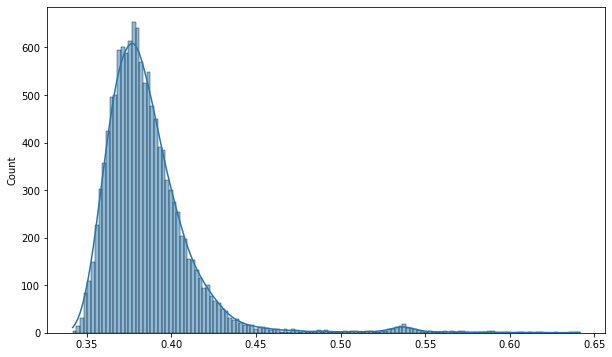

In [56]:
score = -1 * score 

plt.figure(figsize=(10,6))
sns.histplot(score, kde = True)
plt.show()

* validation
    * Score 계산
    * predict로 예측

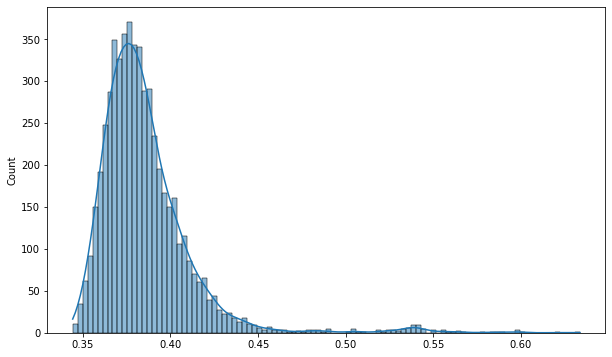

In [57]:
# abnormal 점수 계산
score = model.score_samples(x_val)
score = -1 * score

plt.figure(figsize=(10,6))
sns.histplot(score, kde = True)
plt.show()

In [73]:
# scoring + 분류 : 중 상위 몇 %(contamination 지정한 비율)를 abnormal로 분류
pred = model.predict(x_val)
pred = np.where(pred == 1, 0, 1)

In [74]:
# 분류 결과를 평가해 봅시다.
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5408   37]
 [  37    0]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5445
         1.0       0.00      0.00      0.00        37

    accuracy                           0.99      5482
   macro avg       0.50      0.50      0.50      5482
weighted avg       0.99      0.99      0.99      5482



<ipython-input-3-25383147e64e>:6: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


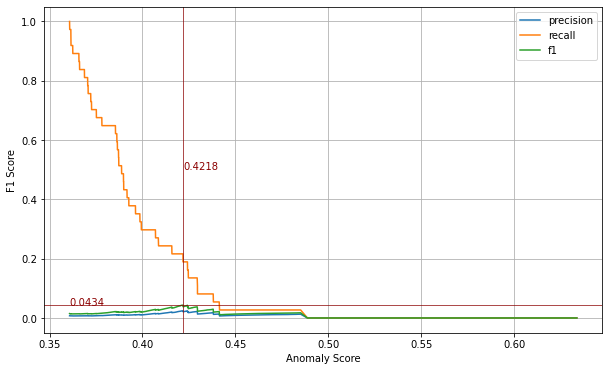

In [62]:
plt.figure(figsize = (10,6))
precision, recall, f1, thresholds = prec_rec_f1_curve(y_val, score)

In [63]:
# f1 score를 최대화 해주는 threshold 값
thresh_max = thresholds[np.argmax(f1)]
print(thresh_max)

0.4217602184139294


In [64]:
classification_report2(y_val, score, thresh_max)

< confusion matrix >

[[5121  324]
 [  30    7]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      5445
         1.0       0.02      0.19      0.04        37

    accuracy                           0.94      5482
   macro avg       0.51      0.56      0.50      5482
weighted avg       0.99      0.94      0.96      5482



array([[5121,  324],
       [  30,    7]], dtype=int64)

## 4.성능 비교

* 성능 평가 : F1 Score


In [35]:
# resampling

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.021857923497267756
-------------------------------------------------------
[[4034 1411]
 [  21   16]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      5445
         1.0       0.01      0.43      0.02        37

    accuracy                           0.74      5482
   macro avg       0.50      0.59      0.44      5482
weighted avg       0.99      0.74      0.84      5482



In [36]:
# class weights 조정

print(f1_score(y_val,pred_cw, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_cw))
print('-' * 55)
print(classification_report(y_val, pred_cw))

0.02097470697100555
-------------------------------------------------------
[[3878 1567]
 [  20   17]]
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83      5445
         1.0       0.01      0.46      0.02        37

    accuracy                           0.71      5482
   macro avg       0.50      0.59      0.43      5482
weighted avg       0.99      0.71      0.82      5482



In [37]:
# isolation forest
classification_report2(y_val, score, thresh_max)


< confusion matrix >

[[5224  221]
 [  32    5]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      5445
         1.0       0.02      0.14      0.04        37

    accuracy                           0.95      5482
   macro avg       0.51      0.55      0.51      5482
weighted avg       0.99      0.95      0.97      5482



array([[5224,  221],
       [  32,    5]], dtype=int64)